# Processamento de Linguagem Natural - Minicurso do SBBD 2022

# Categorização de textos - Análise de sentimentos (polaridade)

Esse código foi desenvolvido para o minicurso de PLN no SBBD 2022.

Autoras: Helena Caseli, Cláudia Freitas e Roberta Viola

https://sites.google.com/view/brasileiras-pln/

Fontes:
* Curso de Linguística Computacional da UFMG - Prof. Thiago Castro Ferreira https://www.youtube.com/playlist?list=PLLrlHSmC0Mw73a1t73DEjgGMPyu8QssWT => Esse código está baseado na aula 7.6
* https://huggingface.co/
* https://github.com/neuralmind-ai/portuguese-bert
* https://pytorch.org/

Esse código:
* Utiliza um modelo neural pré-treinado (BERTimbau), baseado na arquitetura Transformer, com fine-tuning para categorização de texto.
* Categorização de uma review como positiva, neutra ou negativa.

Dataset/corpus:
* B2WReviews-1: https://github.com/b2w-digital/b2w-reviews01

**IMPORTANTE:** Setar a GPU do Colab.

## Instalando as dependências

In [ ]:
!pip3 install transformers

## Baixando o *corpus*

In [ ]:
!wget https://raw.githubusercontent.com/b2w-digital/b2w-reviews01/main/B2W-Reviews01.csv

## Carregando o *corpus*

Se quiser diminuir o tempo de processamento, basta carregar um número menor de instâncias (por exemplo, apenas 10000 instâncias do *corpus* B2W Reviews).

In [ ]:
import pandas as pd
corpus = pd.read_csv('B2W-Reviews01.csv', sep=',', quotechar='\"', nrows=10000)

corpus.dropna(subset=["review_text"],inplace=True)

corpus.head(1)


Separando apenas as informações que vamos usar no *fine-tuning* que será realizado com base apenas no texto das revisões de produto (```review_text```).

Vamos também fazer um processamento nas informações originais de ```overall_rating``` agrupando as notas 4 e 5 na classe positiva (2), nota 3 na classe neutra (1) e notas 1 e 2 na classe negativa (0).

In [ ]:
df = corpus.loc[:, ("review_text", "overall_rating")]
df["label"] = corpus["overall_rating"].replace({5: 2, 4: 2, 3: 1, 2: 0, 1: 0})
df.head(20)

,review_text,overall_rating,label
0,Estou contente com a compra entrega rápida o ú...,4,2
1,"Por apenas R$1994.20,eu consegui comprar esse ...",4,2
2,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,4,2
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,4,2
4,"A entrega foi no prazo, as americanas estão de...",5,2
5,"Excelente produto, por fora em material acríli...",5,2
6,"produto mto bom, com essa garrafinha vc pode a...",5,2
7,Produto excelente qualidade boa câmera desenvo...,4,2
8,O barulho e minimo e o vento é bem forte na ve...,5,2
9,MEU PRODUTO NAO FOI ENTREGUE E A AMERICANAS ES...,1,0


Vamos dar uma olhada na distribuição das instâncias nas 3 classes resultantes.

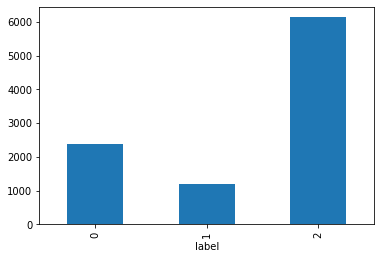

In [ ]:
df.groupby(['label']).size().plot.bar()

## Separando o *corpus* em treinamento e teste

Vamos separar 80% para treinamento e deixar 20% para teste.

In [ ]:
from sklearn.model_selection import train_test_split
treino, teste = train_test_split(df, stratify=df["label"], test_size=0.2) #train_size=0.8, shuffle=True)

len(treino), len(teste)

(7772, 1944)

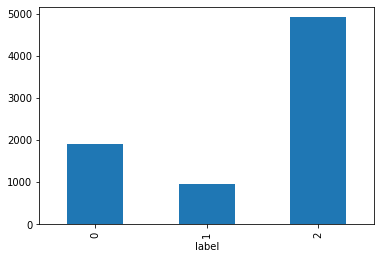

In [ ]:
treino.groupby(['label']).size().plot.bar()

## Preparando o *fine-tuning*



In [ ]:
def get_features(info):   
  x = info["review_text"] 
  y = info["label"]
  return { 'X': x, 'y': y }

Importando dependências.

Para mais informações sobre essas dependências/bibliotecas, consulte: https://github.com/neuralmind-ai/portuguese-bert

In [ ]:
import os
import torch
import torch.nn as nn
from torch import optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report  

Setando os parâmetros da rede neural.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nclasses = 3
nepochs = 5
batch_size = 8
batch_status = 32
learning_rate = 1e-5  # usar uma bem baixa para o caso dos modelos pré-treinados
early_stop = 2        # se em duas épocas consecutivas o resultado não melhorar no conjunto de validação, então para o treinamento

max_length = 180      # todas as sequências com mais de 180 tokens serão truncadas para considerar só os 180 primeiros
write_path = 'model'

Instanciando tokenizador, modelo, função de erro, otimizador e dados de treinamento e teste em lotes

In [ ]:
from torch.utils.data import DataLoader, Dataset

traindata = DataLoader([get_features(treino.iloc[i]) for i in range(len(treino))], batch_size=batch_size, shuffle=True)
testdata = DataLoader([get_features(teste.iloc[i]) for i in range(len(teste))], batch_size=batch_size, shuffle=True)

Aqui, como estamos usando os textos das *reviews* como a *feature* para o *fine-tuning*, vamos usar o modelo pré-treinado do BERTimbau para SequenceClassification.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)
model = AutoModelForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=nclasses).to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Definindo o método de avaliação.

Veja que aqui fazemos a chamada ao ```tokenizer``` do BERT. Esse tokenizador transforma a sentença de entrada para o formato esperado pelo BERT nessa tarefa, que é inserindo um *token* [CLS] no início da sentença e [SEP] ao final. Esse é o formato esperado pelo BERT para tarefas de *single text classification*.

Outro processamento feito no código abaixo é setar o ```padding``` que completa (com o *token* especial [PAD]) ou trunca a sequência de *tokens* para ficar dentro do limite estabelecido (```max_length```).

A saída da classificação (em ```output```) é uma *embedding* associada ao *token* [CLS].

In [ ]:
def evaluate(model, testdata):
  model.eval()
  y_real, y_pred = [], []
  for batch_idx, inp in enumerate(testdata):
    texts, labels = inp['X'], inp['y']
    
    # classificando
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    output = model(**inputs) # output contém as probabilidades da entrada pertencer a uma das classes
                
    pred_labels = torch.argmax(output.logits, 1)
    
    y_real.extend(labels.tolist())
    y_pred.extend(pred_labels.tolist())
    
    if (batch_idx+1) % batch_status == 0:
      print('Progresso:', round(batch_idx / len(testdata), 2), batch_idx)
  
  print(classification_report(y_real, y_pred, labels=[0, 1, 2], target_names=['Negativa', 'Neutra', 'Positiva']))
  f1 = f1_score(y_real, y_pred, average='weighted')
  acc = accuracy_score(y_real, y_pred)
  return f1, acc

## Treinamento

**IMPORTANTE:** Setar a GPU do Colab.

In [ ]:
max_f1, repeat = 0, 0
for epoch in range(nepochs):
  model.train()
  f1, acc = evaluate(model, testdata)
  losses = []
  for batch_idx, inp in enumerate(traindata):
    texts, labels = inp['X'], inp['y']

    # classificando
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    output = model(**inputs, labels=labels.to(device))

    # Calculando a loss (erro)
    loss = output.loss
    losses.append(float(loss))

    # Backpropagation com base no erro
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Informando o andamneto
    if (batch_idx+1) % batch_status == 0:
      print('Epoca de treinamento: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTotal Loss: {:.6f}'.format(epoch, \
        batch_idx+1, len(traindata), 100. * batch_idx / len(traindata), 
        float(loss), round(sum(losses) / len(losses), 5)))
  
  f1, acc = evaluate(model, testdata)
  print('F1: ', f1, 'Accuracy: ', acc)
  if f1 > max_f1:
    model.save_pretrained(os.path.join(write_path, 'model'))
    max_f1 = f1
    repeat = 0
    print('Salvando o melhor modelo ...')
  else:
    repeat += 1
  
  if repeat == early_stop:
    break

Progress: 0.13 31
Progress: 0.26 63
Progress: 0.39 95
Progress: 0.52 127
Progress: 0.65 159
Progress: 0.79 191
Progress: 0.92 223
              precision    recall  f1-score   support

    Negativa       0.33      0.00      0.01       476
      Neutra       0.00      0.00      0.00       240
    Positiva       0.63      1.00      0.77      1228

    accuracy                           0.63      1944
   macro avg       0.32      0.33      0.26      1944
weighted avg       0.48      0.63      0.49      1944

Train Epoch: 0 [32/972 (3%)]	Loss: 0.820846	Total Loss: 0.876210
Train Epoch: 0 [64/972 (6%)]	Loss: 0.765200	Total Loss: 0.803460
Train Epoch: 0 [96/972 (10%)]	Loss: 0.466072	Total Loss: 0.720650
Train Epoch: 0 [128/972 (13%)]	Loss: 0.146775	Total Loss: 0.633540
Train Epoch: 0 [160/972 (16%)]	Loss: 0.202871	Total Loss: 0.611720
Train Epoch: 0 [192/972 (20%)]	Loss: 0.127982	Total Loss: 0.593530
Train Epoch: 0 [224/972 (23%)]	Loss: 0.512627	Total Loss: 0.579010
Train Epoch: 0 [256/972 (

## Predição

Depois do treinamento do modelo, podemos usá-lo para fazer predições em novas *reviews*.

In [ ]:
val_X = ["Odiei! Eu não recomendo o produto", "mais ou menos", "Adorei, vou usar muuuuuiiiiito"]
val_y = []

for x in val_X:
  inputs = tokenizer(x, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
  output = model(**inputs)
  
  pred_labels = torch.argmax(output.logits, 1)
  
  val_y.append(pred_labels)

val_y

[tensor([0], device='cuda:0'),
 tensor([1], device='cuda:0'),
 tensor([2], device='cuda:0')]

Testando o modelo para a sentença de exemplo do Capítulo que acompanha o minicurso.

In [ ]:
inputs = tokenizer("Com estas palavras, André Coruja, além de quebrar o gelo que havia esfriado o clima, devolveu ao recinto a eloquência necessária para que a sessão continuasse.", return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
output = model(**inputs)
  
pred_labels = torch.argmax(output.logits, 1)
  
pred_labels


tensor([2], device='cuda:0')

Fim deste exemplo.